In [ ]:
!pip install scikit-learn
!pip install pandas
!pip install matplotlib
!pip install numpy

### Импорт необходимых библиотек

In [ ]:
# DELETE UNUSED LATER
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.impute import SimpleImputer
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression, ElasticNetCV
from warnings import simplefilter
from sklearn.neighbors import KNeighborsClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.svm import NuSVC
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle
import functools
%matplotlib inline
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

from google.colab import drive
drive.mount('/content/drive')
# Now notebook uses google drive, all file paths were rewriten
# Drop datasets' folders into google drive's root

Mounted at /content/drive


### Работа с данными

#### Описание датасета

Директории train и test - данные для обучения и прогнозирования соответственно

Каждая директория содержит 10 файлов. 9 файлов вида B**.csv - значения каналов, файл NDVI.csv - рассчитанное значение индекса NDVI.

Каждый файл содержит 26 числовых столбцов со значениями каналов в k-ый день от начала года. Также данные для обучения содержат столбец culture с названием выращиваемой культуры.

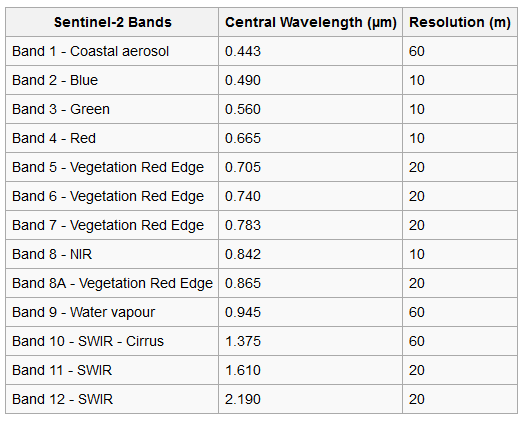

##### Training pipeline

['овощи', 'соя', 'кукуруза', 'залежь', 'многолетние травы', 'зерновые']


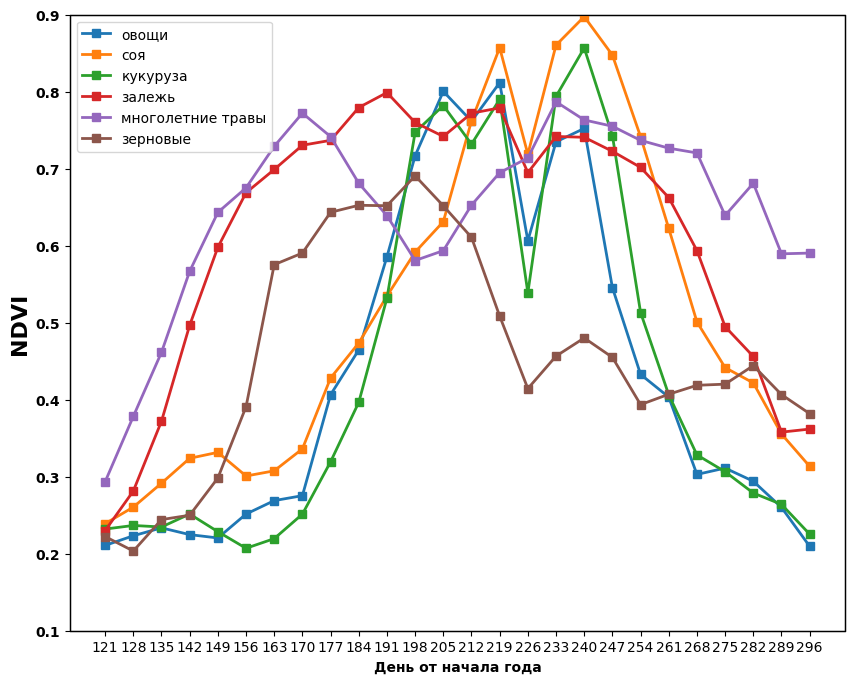

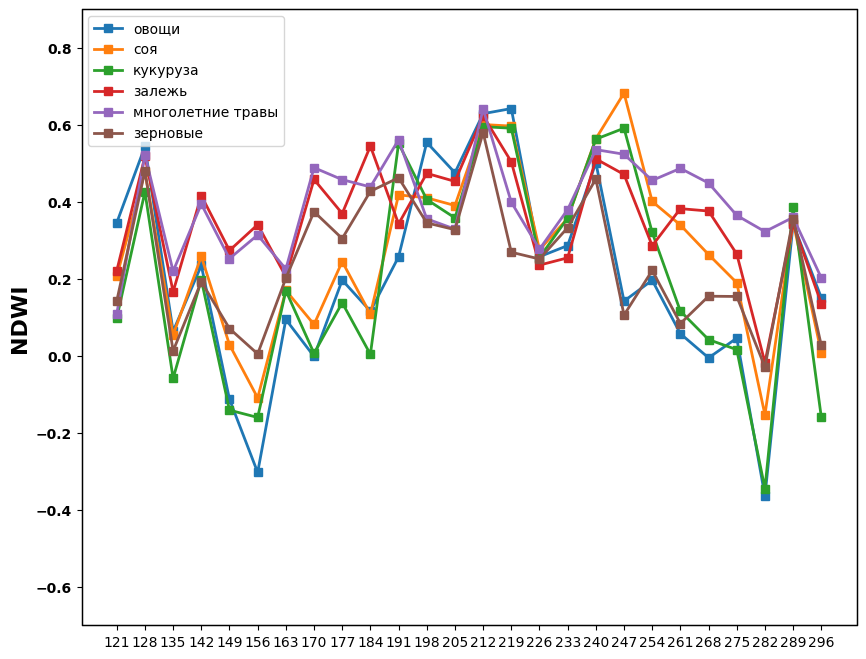

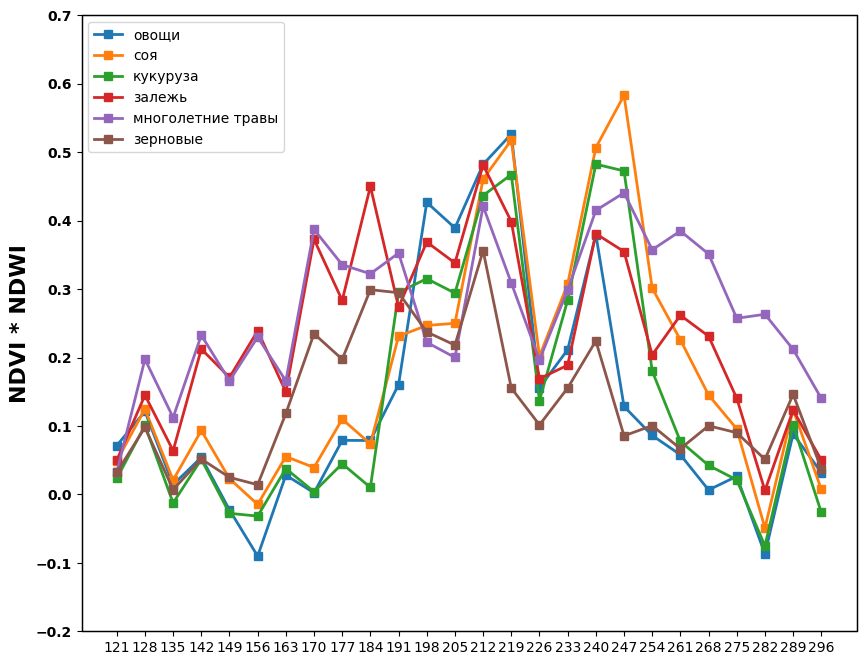

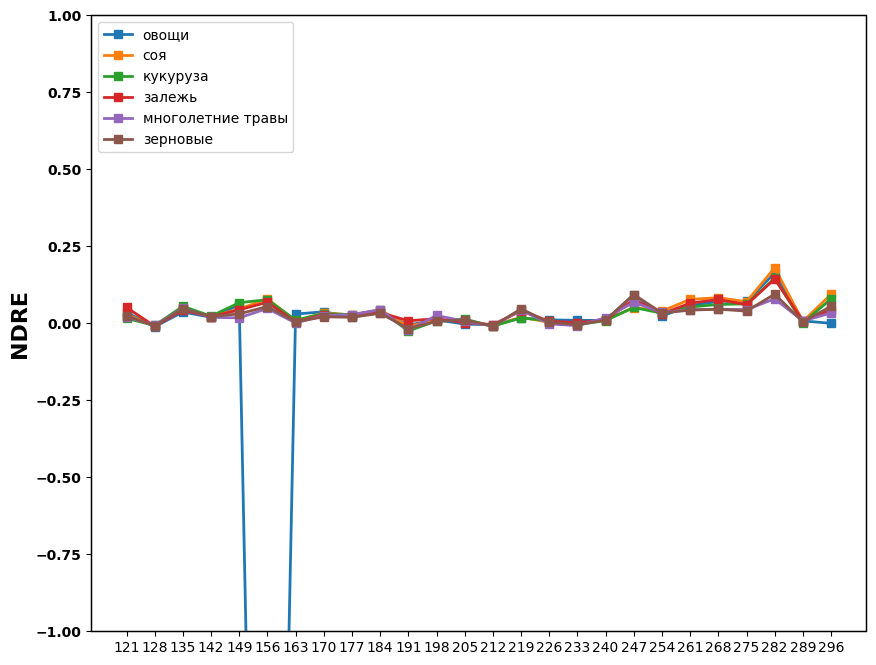

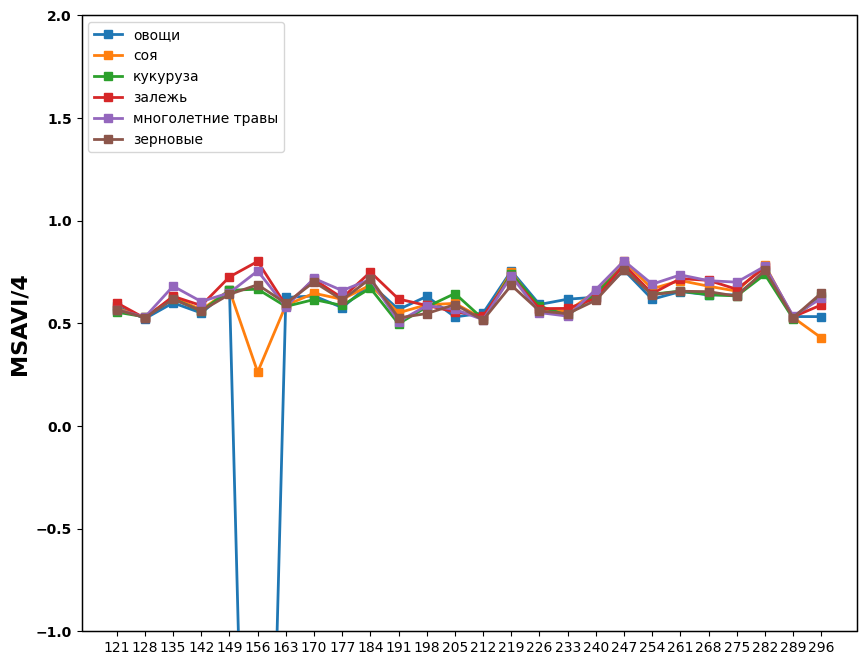

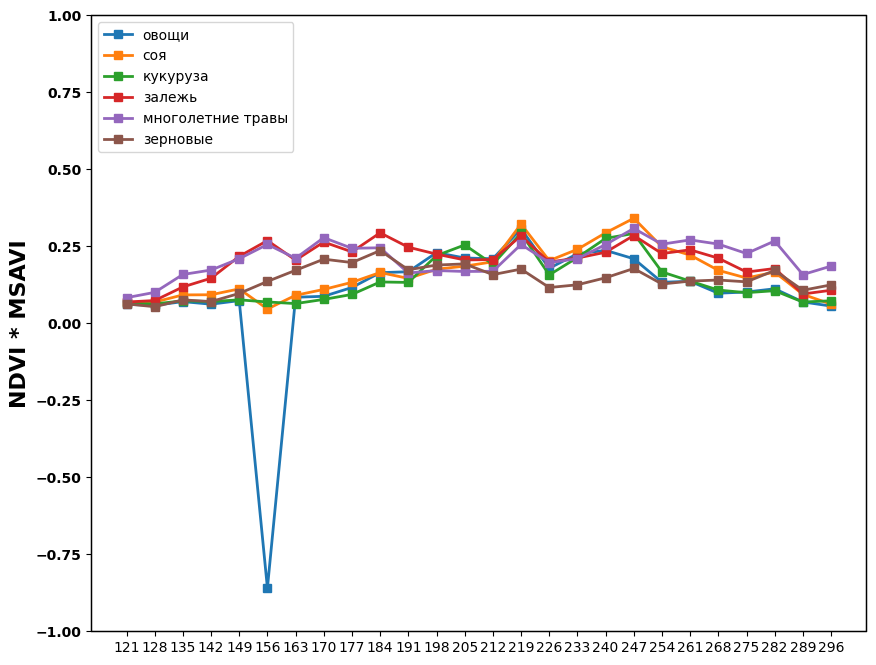

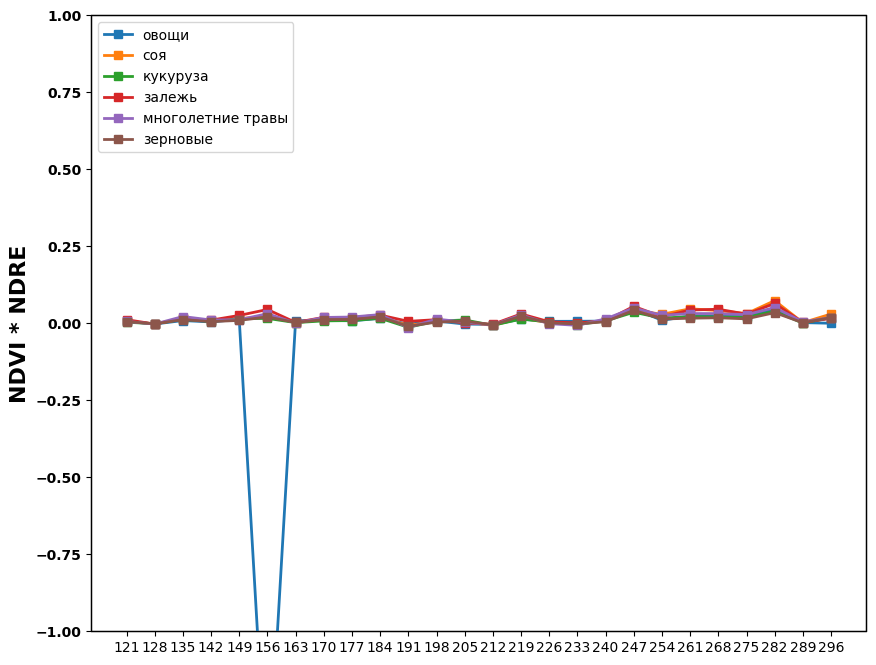

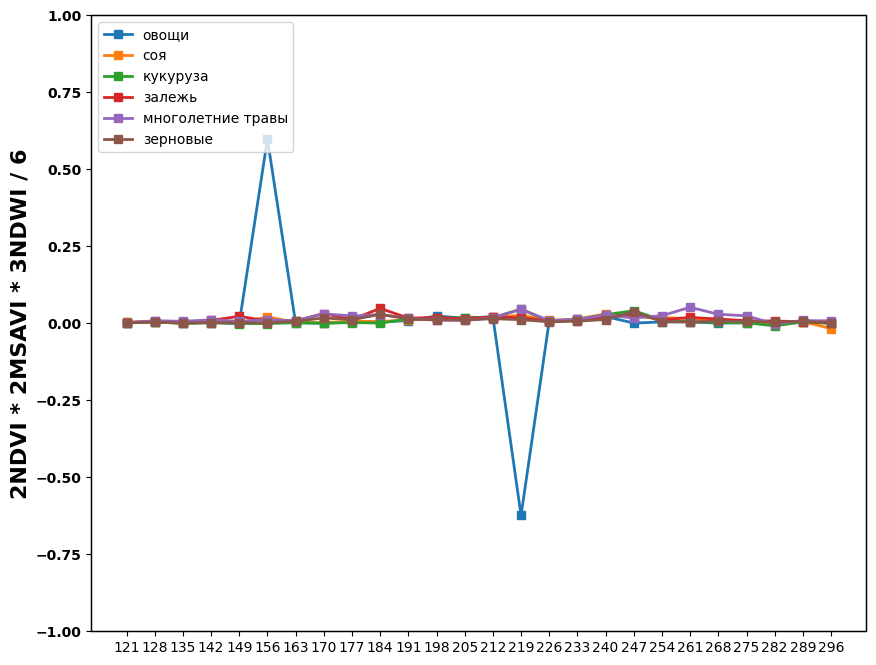

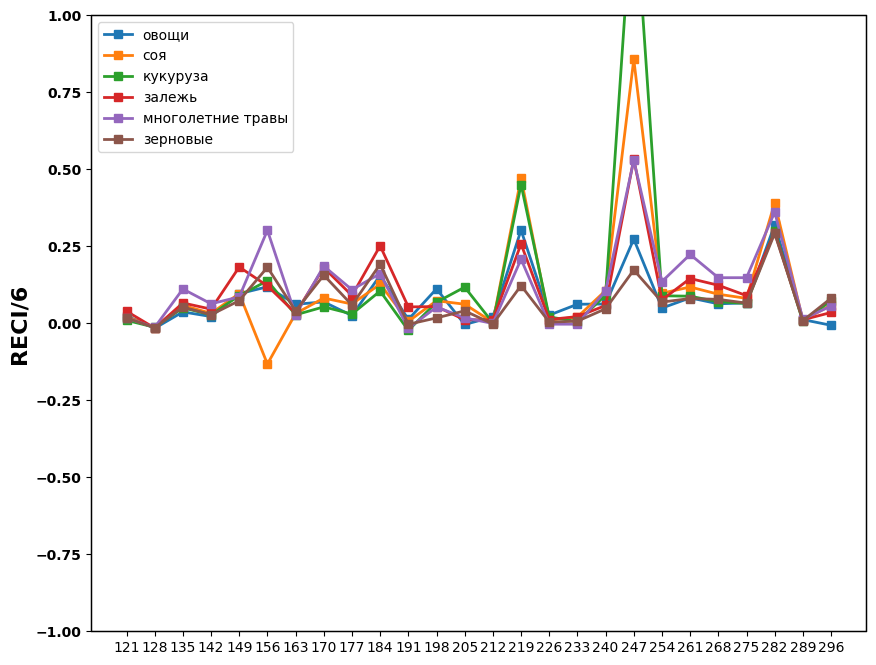

In [ ]:
#@title Main training datasets
df_ndvi = pd.read_csv("drive/MyDrive/train/NDVI.csv", encoding="windows-1251")
df_re5 = pd.read_csv("drive/MyDrive/train/B05.csv", encoding="windows-1251")  # B05 - канал со значениями RedEdge 705nm
df_nir = pd.read_csv("drive/MyDrive/train/B8A.csv", encoding="windows-1251")  # B8A - канал со значениями NIR
df_swir = pd.read_csv("drive/MyDrive/train/B12.csv", encoding="windows-1251")  # B12 - канал со значениями SWIR
df_re = pd.read_csv("drive/MyDrive/train/B07.csv", encoding="windows-1251")  # B07 - канал со значениями RedEdge
df_red = pd.read_csv("drive/MyDrive/train/B04.csv", encoding="windows-1251")  # B04 - канал со значениями Red
df_blue = pd.read_csv("drive/MyDrive/train/B02.csv", encoding="windows-1251")  # B04 - канал со значениями Blue
df_green = pd.read_csv("drive/MyDrive/train/B03.csv", encoding="windows-1251") # B03 - канал со значениями Green
df_sir = pd.read_csv("drive/MyDrive/train/B11.csv", encoding="windows-1251") # B03 - канал со значениями SWIR 11 band
df_re6 = pd.read_csv("drive/MyDrive/train/B06.csv", encoding="windows-1251")  # B06 - канал со значениями RedEdge 740nm
df_red = df_red.drop(columns=["index"])
df_blue = df_blue.drop(columns=["index"])
df_sir = df_sir.drop(columns=["index"])
df_green = df_green.drop(columns=["index"])
df_re = df_re.drop(columns=["index"])
df_ndvi = df_ndvi.drop(columns=["index"])
df_re5 = df_re5.drop(columns=["index"])
df_re6 = df_re6.drop(columns=["index"])
df_swir = df_swir.drop(columns=["index"])
df_nir = df_nir.drop(columns=["index"])  # Удалим столбец с индексами, в данном примере они не понадобятся
cul = list(df_ndvi['culture'].unique().tolist())
print(cul)
fig, ax = plt.subplots(figsize=(10,8))

plt.yticks(fontsize=10)

ax.set_xlabel('День от начала года',fontsize = 10,fontweight="bold")
ax.set_ylabel('NDVI',fontsize = 16,fontweight="bold")
ax.patch.set_edgecolor('black')

ax.patch.set_linewidth(1)
plt.ylim([0.1, 0.9])


xx = ['121', '128', '135', '142', '149', '156', '163', '170', '177', '184', '191', '198', '205', '212', '219', '226', '233', '240', '247', '254', '261', '268', '275', '282', '289', '296']
colors = plt.cm.coolwarm(np.array(len(cul)))
for i in range(len(cul)):
    p = df_ndvi.loc[(df_ndvi['culture'] == cul[i])].drop(columns=['culture']).mean()
    ax.plot(xx, p.values.tolist(), label=cul[i], linestyle = '-', marker = 's', markersize = 6, linewidth = 2)
plt.yticks(size=10, fontweight="bold")
leg = ax.legend(fontsize=10, loc ='upper left')

plt.show()
# modified

fig, ax = plt.subplots(figsize=(10,8))
plt.yticks(fontsize=10)
ax.patch.set_edgecolor('black')
ax.patch.set_linewidth(1)

ax.set_ylabel('NDWI',fontsize = 16,fontweight="bold")
plt.ylim([-0.7, 0.9])

# create index's dataframe
df_ndwi = pd.DataFrame()
for day in xx:  # Переберем все дни и создадим новый признак для каждого дня
    df_ndwi[f"{day}"] = (df_nir[day] - df_swir[day]) / (df_nir[day] + df_swir[day])
df_ndwi[f"culture"] = df_nir["culture"]

# Process and make plot
for i in range(len(cul)):
    p = df_ndwi.loc[(df_ndwi['culture'] == cul[i])].drop(columns=['culture']).mean()
    ax.plot(xx, p.values.tolist(), label=cul[i], linestyle='-', marker='s', markersize=6, linewidth=2)
plt.yticks(size=10, fontweight="bold")
leg = ax.legend(fontsize=10, loc ='upper left')

plt.show()
#

fig, ax = plt.subplots(figsize=(10,8))
plt.yticks(fontsize=10)
ax.patch.set_edgecolor('black')
ax.patch.set_linewidth(1)

ax.set_ylabel('NDVI * NDWI',fontsize = 16,fontweight="bold")
plt.ylim([-0.2, 0.7])

# create index's dataframe
df_ndvwi = pd.DataFrame()
for day in xx:  # Переберем все дни и создадим новый признак для каждого дня
    df_ndvwi[f"{day}"] = df_ndvi[day] * df_ndwi[day]
df_ndvwi[f"culture"] = df_nir["culture"]

# Process and make plot
for i in range(len(cul)):
    p = df_ndvwi.loc[(df_ndvwi['culture'] == cul[i])].drop(columns=['culture']).mean()
    ax.plot(xx, p.values.tolist(), label=cul[i], linestyle = '-', marker = 's', markersize = 6, linewidth = 2)
plt.yticks(size=10, fontweight="bold")
leg = ax.legend(fontsize=10, loc ='upper left')

plt.show()
#

fig, ax = plt.subplots(figsize=(10,8))
plt.yticks(fontsize=10)
ax.patch.set_edgecolor('black')
ax.patch.set_linewidth(1)

ax.set_ylabel('NDRE',fontsize = 16,fontweight="bold")
plt.ylim([-1.0, 1.0])

# create index's dataframe
df_ndre = pd.DataFrame()
for day in xx:  # Переберем все дни и создадим новый признак для каждого дня
    df_ndre[f"{day}"] = ((df_nir[day] - df_re[day]) / (df_nir[day] + df_re[day]))
df_ndre[f"culture"] = df_nir["culture"]

# Process and make plot
for i in range(len(cul)):
    p = df_ndre.loc[(df_ndre['culture'] == cul[i])].drop(columns=['culture']).mean()
    ax.plot(xx, p.values.tolist(), label=cul[i], linestyle = '-', marker = 's', markersize = 6, linewidth = 2)
plt.yticks(size=10, fontweight="bold")
leg = ax.legend(fontsize=10, loc ='upper left')

plt.show()
#

fig, ax = plt.subplots(figsize=(10,8))
plt.yticks(fontsize=10)
ax.patch.set_edgecolor('black')
ax.patch.set_linewidth(1)

ax.set_ylabel('MSAVI/4',fontsize = 16,fontweight="bold")
plt.ylim([-1.0, 2.0])

# create index's dataframe
df_msavi = pd.DataFrame()
for day in xx:  # Переберем все дни и создадим новый признак для каждого дня
    df_msavi[f"{day}"] = ((2*(df_nir[day] + 1)) - ((2*df_nir[day]+1)**2 - 8 * (df_nir[day] - df_red[day])) ** (0.5)) / 8 + 0.4
df_msavi[f"culture"] = df_nir["culture"]

# Process and make plot
for i in range(len(cul)):
    p = df_msavi.loc[(df_msavi['culture'] == cul[i])].drop(columns=['culture']).mean()
    ax.plot(xx, p.values.tolist(), label=cul[i], linestyle = '-', marker = 's', markersize = 6, linewidth = 2)
plt.yticks(size=10, fontweight="bold")
leg = ax.legend(fontsize=10, loc ='upper left')

plt.show()
#

fig, ax = plt.subplots(figsize=(10,8))
plt.yticks(fontsize=10)
ax.patch.set_edgecolor('black')
ax.patch.set_linewidth(1)

ax.set_ylabel('NDVI * MSAVI',fontsize = 16,fontweight="bold")
plt.ylim([-1.0, 1.0])

# create index's dataframe
df_ndmsavi = pd.DataFrame()
for day in xx:  # Переберем все дни и создадим новый признак для каждого дня
    df_ndmsavi[f"{day}"] = df_ndvi[day] * (df_msavi[day] / 2)
df_ndmsavi[f"culture"] = df_nir["culture"]

# Process and make plot
for i in range(len(cul)):
    p = df_ndmsavi.loc[(df_ndmsavi['culture'] == cul[i])].drop(columns=['culture']).mean()
    ax.plot(xx, p.values.tolist(), label=cul[i], linestyle = '-', marker = 's', markersize = 6, linewidth = 2)
plt.yticks(size=10, fontweight="bold")
leg = ax.legend(fontsize=10, loc ='upper left')

plt.show()
#

fig, ax = plt.subplots(figsize=(10,8))
plt.yticks(fontsize=10)
ax.patch.set_edgecolor('black')
ax.patch.set_linewidth(1)

ax.set_ylabel('NDVI * NDRE',fontsize = 16,fontweight="bold")
plt.ylim([-1.0, 1.0])

# create index's dataframe
df_vire = pd.DataFrame()
for day in xx:  # Переберем все дни и создадим новый признак для каждого дня
    df_vire[f"{day}"] = df_ndvi[day] * df_ndre[day]
df_vire[f"culture"] = df_nir["culture"]

# Process and make plot
for i in range(len(cul)):
    p = df_vire.loc[(df_vire['culture'] == cul[i])].drop(columns=['culture']).mean()
    ax.plot(xx, p.values.tolist(), label=cul[i], linestyle = '-', marker = 's', markersize = 6, linewidth = 2)
plt.yticks(size=10, fontweight="bold")
leg = ax.legend(fontsize=10, loc ='upper left')

plt.show()
#

fig, ax = plt.subplots(figsize=(10,8))
plt.yticks(fontsize=10)
ax.patch.set_edgecolor('black')
ax.patch.set_linewidth(1)

ax.set_ylabel('2NDVI * 2MSAVI * 3NDWI / 6',fontsize = 16,fontweight="bold")
plt.ylim([-1.0, 1.0])

# create index's dataframe
df_ndawi = pd.DataFrame()
for day in xx:  # Переберем все дни и создадим новый признак для каждого дня
    df_ndawi[f"{day}"] = ((((df_ndvi[day] * 2) * df_green[day] / 10) * ((df_msavi[day] * 2) * (df_ndwi[day] * 3) / df_red[day] * 2))) / 30
df_ndawi[f"culture"] = df_nir["culture"]

# Process and make plot
for i in range(len(cul)):
    p = df_ndawi.loc[(df_ndawi['culture'] == cul[i])].drop(columns=['culture']).mean()
    ax.plot(xx, p.values.tolist(), label=cul[i], linestyle = '-', marker = 's', markersize = 6, linewidth = 2)
plt.yticks(size=10, fontweight="bold")
leg = ax.legend(fontsize=10, loc ='upper left')

plt.show()
#

fig, ax = plt.subplots(figsize=(10,8))
plt.yticks(fontsize=10)
ax.patch.set_edgecolor('black')
ax.patch.set_linewidth(1)

ax.set_ylabel('RECI/6',fontsize = 16,fontweight="bold")
plt.ylim([-1.0, 1.0])

# create index's dataframe
df_reci = pd.DataFrame()
for day in xx:  # Переберем все дни и создадим новый признак для каждого дня
    df_reci[f"{day}"] = ((df_nir[day] - df_re5[day]) / (2 * df_re5[day] - df_red[day])) / 6
df_reci[f"culture"] = df_nir["culture"]

# Process and make plot
for i in range(len(cul)):
    p = df_reci.loc[(df_reci['culture'] == cul[i])].drop(columns=['culture']).mean()
    ax.plot(xx, p.values.tolist(), label=cul[i], linestyle = '-', marker = 's', markersize = 6, linewidth = 2)
plt.yticks(size=10, fontweight="bold")
leg = ax.legend(fontsize=10, loc ='upper left')

plt.show()

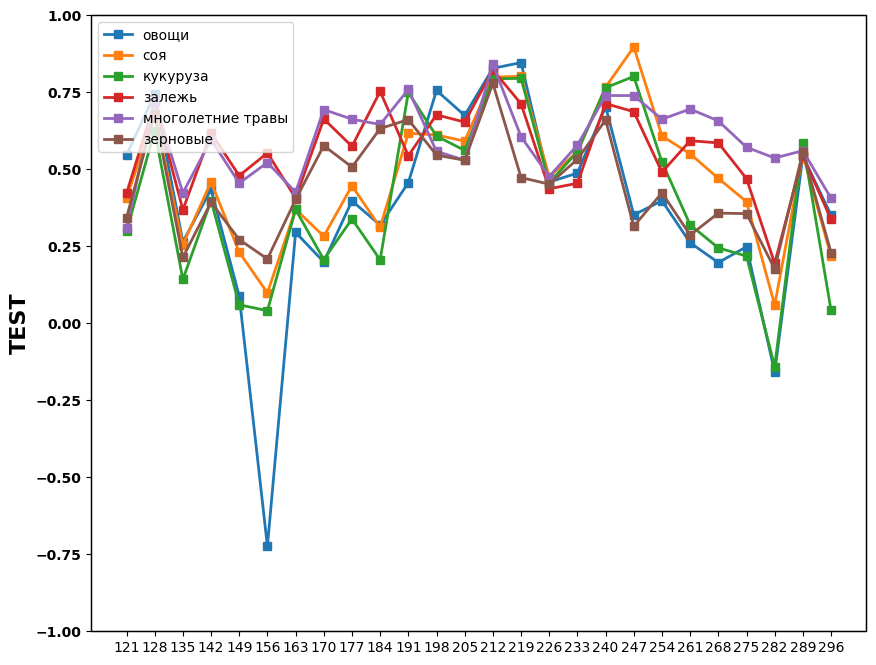

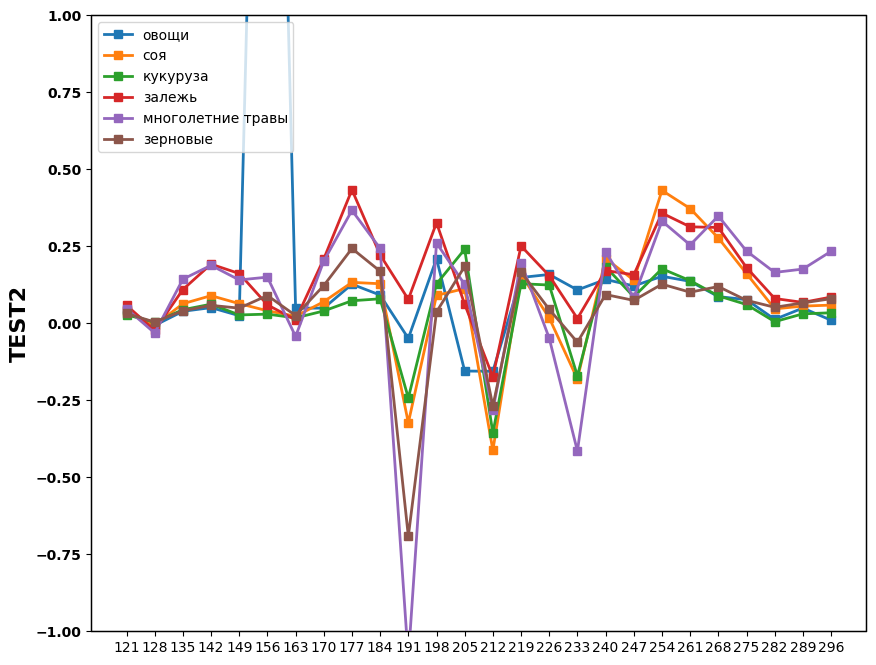

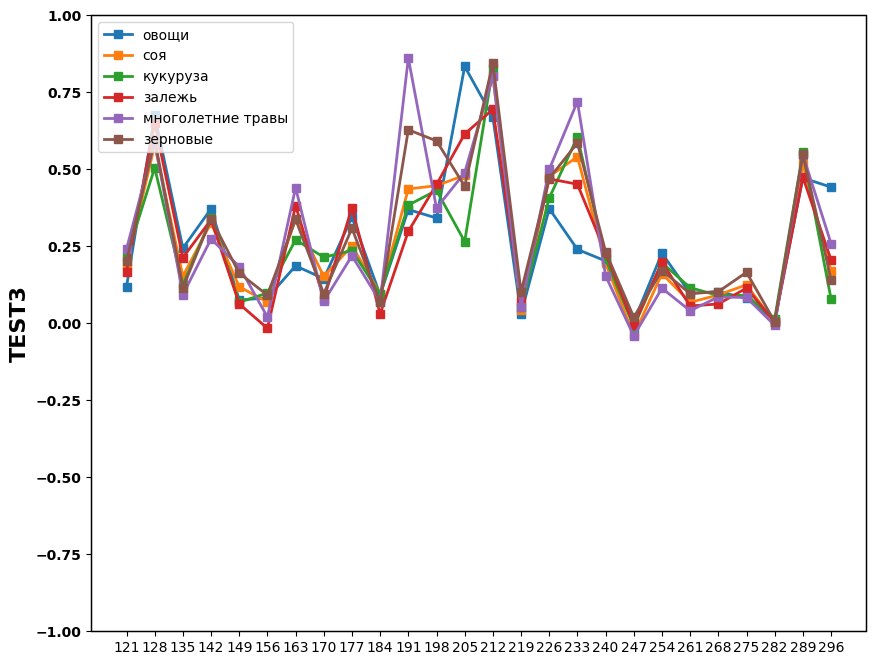

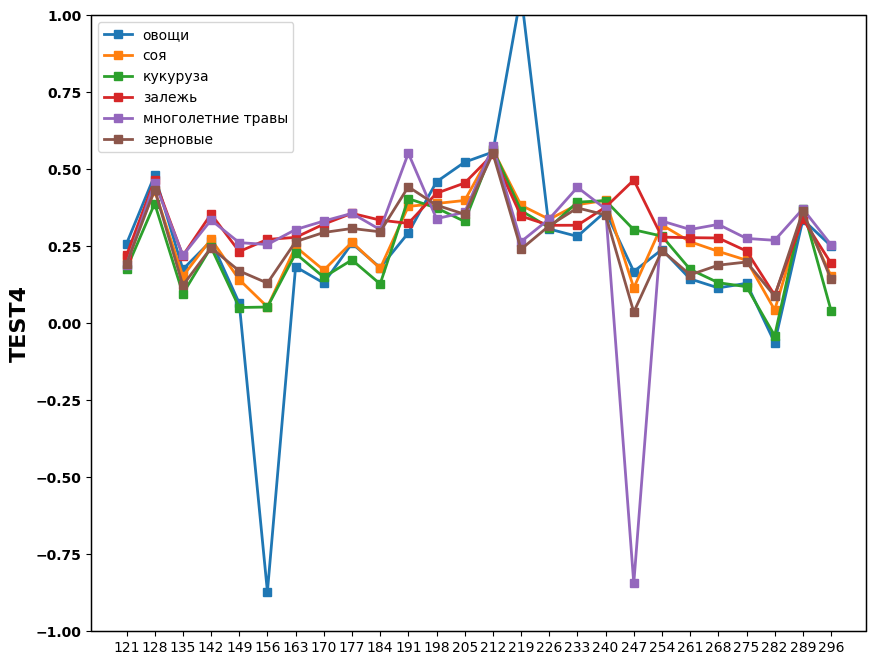

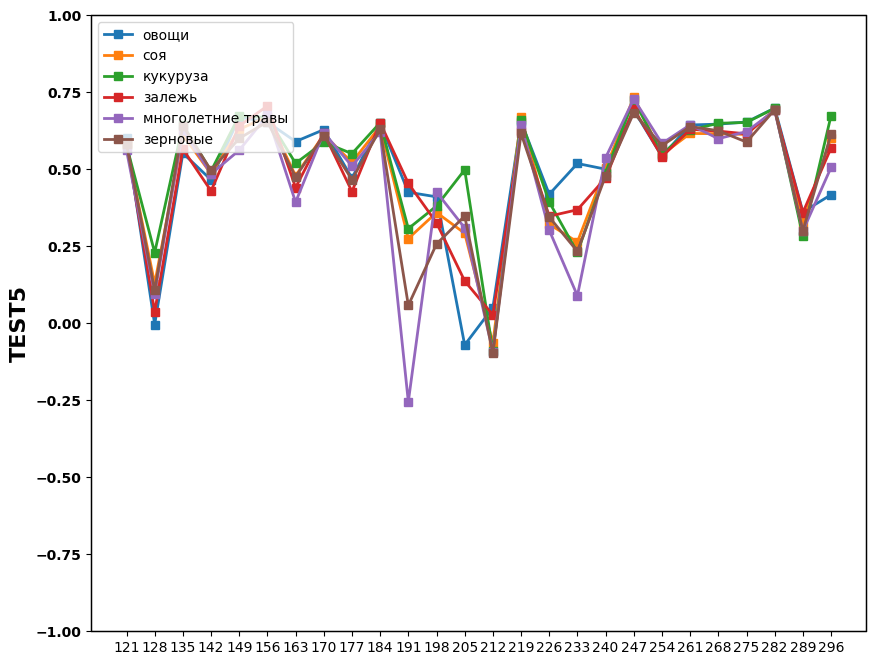

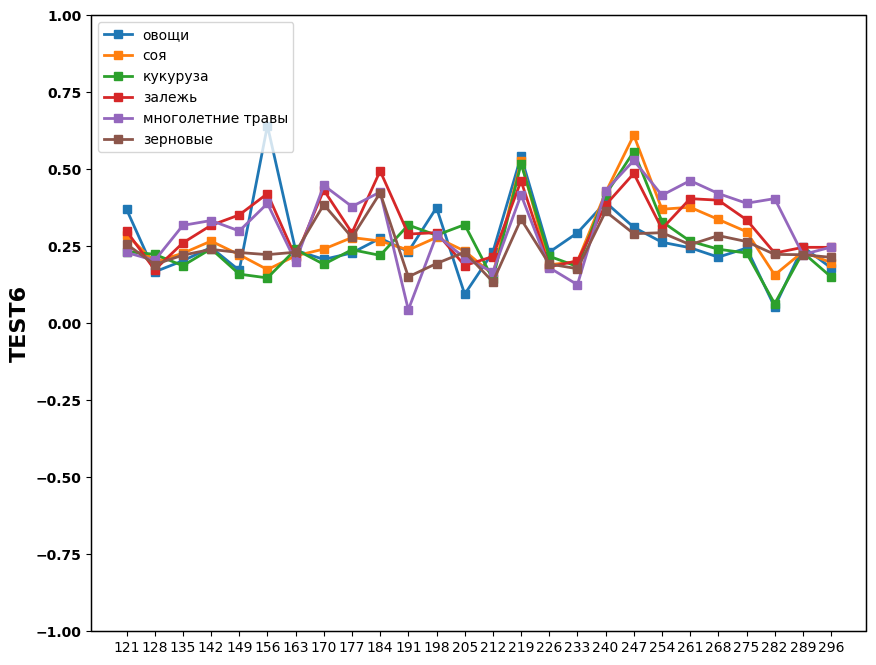

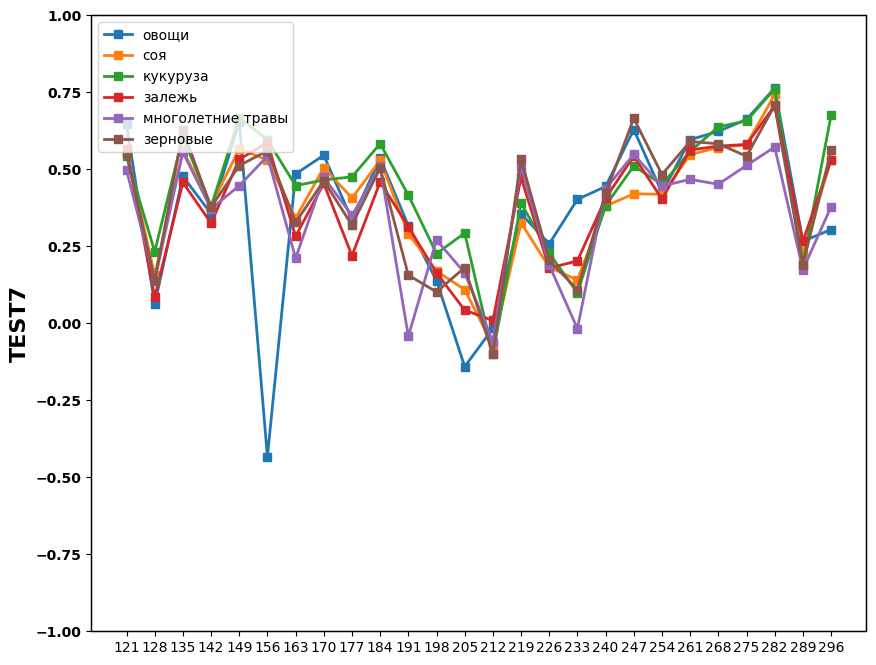

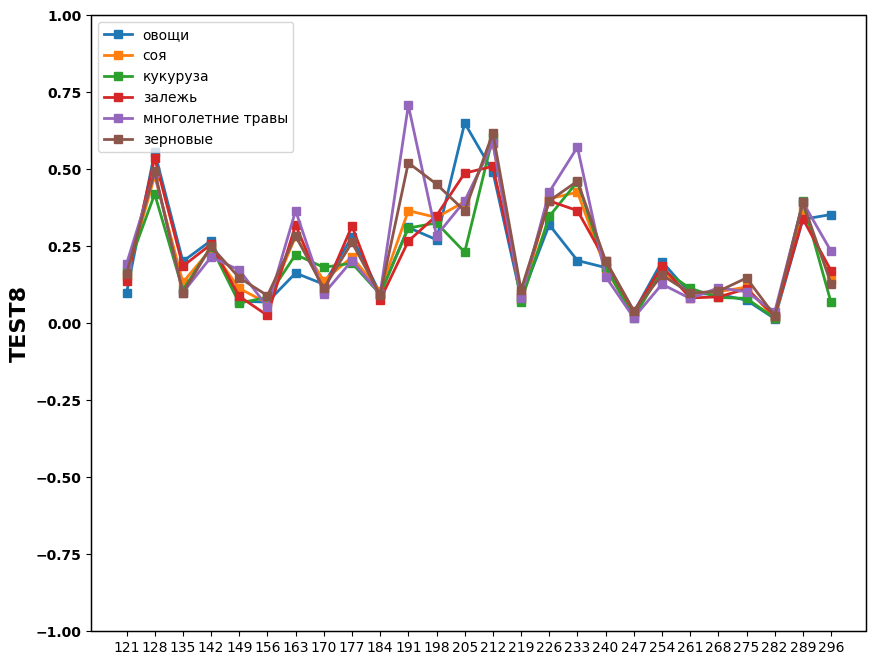

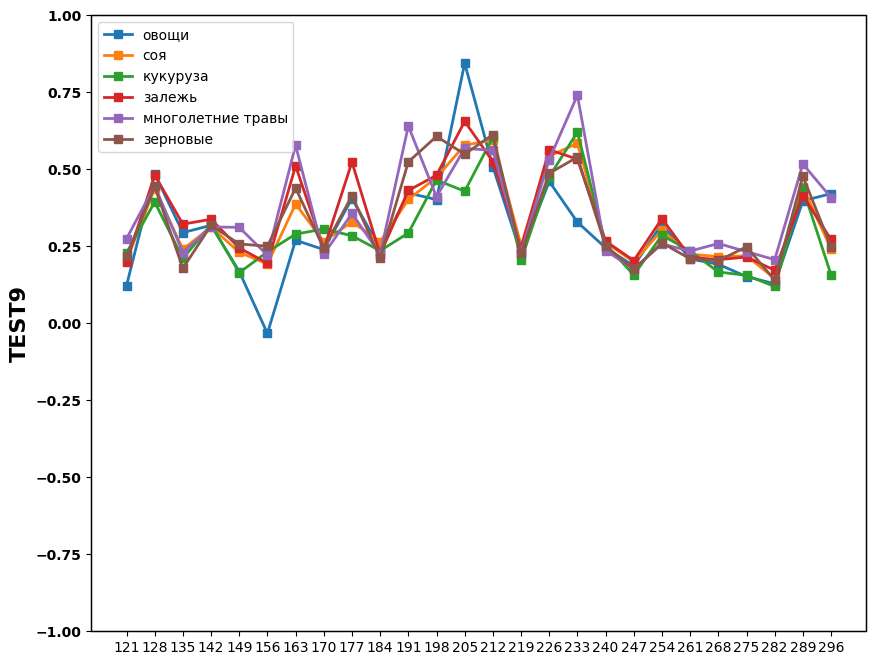

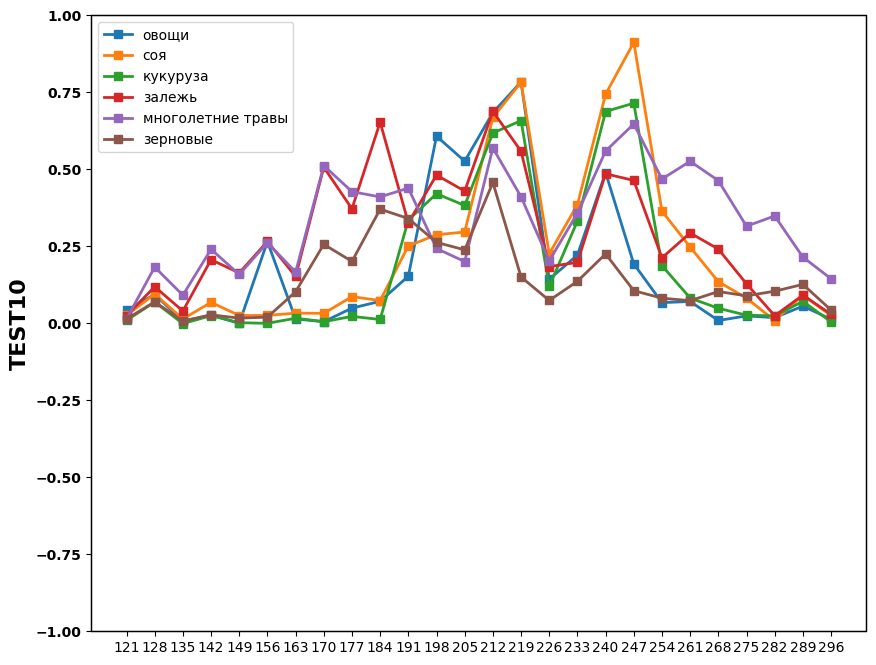

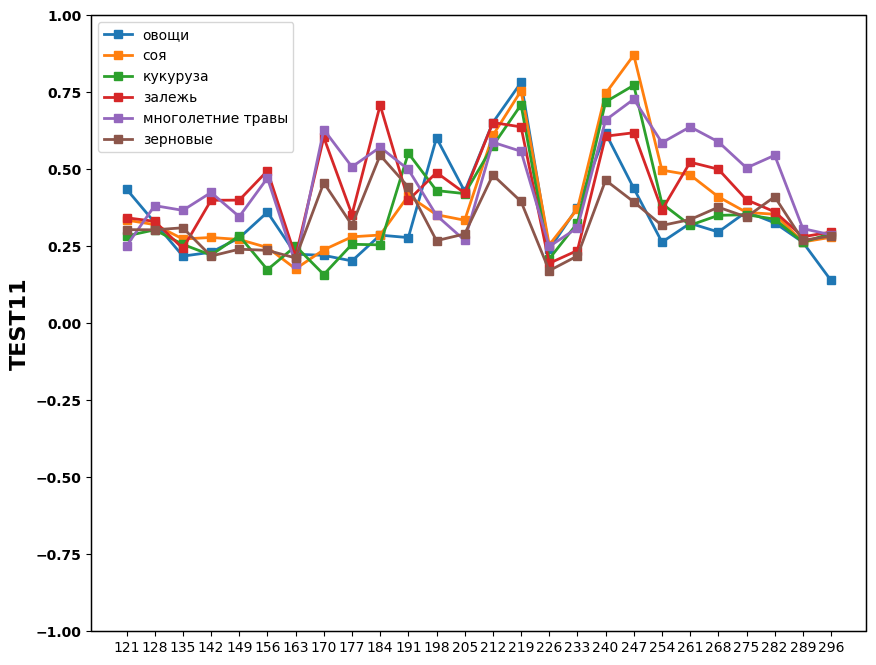

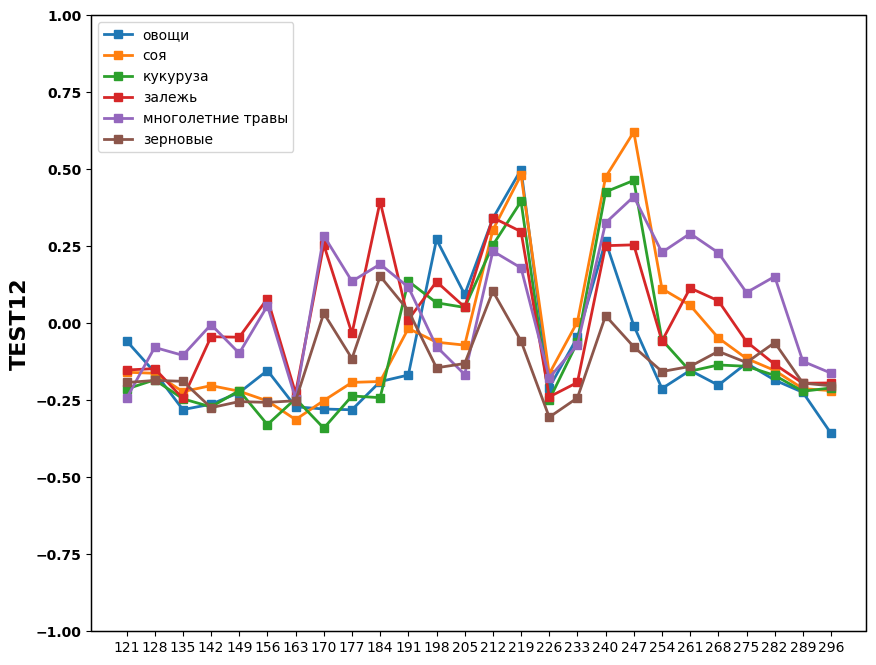

In [ ]:
#@title Test training datasets
fig, ax = plt.subplots(figsize=(10,8))
plt.yticks(fontsize=10)
ax.patch.set_edgecolor('black')
ax.patch.set_linewidth(1)

ax.set_ylabel('TEST',fontsize = 16,fontweight="bold")
plt.ylim([-1.0, 1.0])

# create index's dataframe
df_test = pd.DataFrame()
for day in xx:  # Переберем все дни и создадим новый признак для каждого дня
    df_test[f"{day}"] = df_ndvi[day] * (df_msavi[day] / 2) * (df_ndvi[day] * df_ndre[day]) + df_ndwi[day] + 0.2
df_test[f"culture"] = df_nir["culture"]

# Process and make plot
for i in range(len(cul)):
    p = df_test.loc[(df_test['culture'] == cul[i])].drop(columns=['culture']).mean()
    ax.plot(xx, p.values.tolist(), label=cul[i], linestyle = '-', marker = 's', markersize = 6, linewidth = 2)
plt.yticks(size=10, fontweight="bold")
leg = ax.legend(fontsize=10, loc ='upper left')

plt.show()
#

fig, ax = plt.subplots(figsize=(10,8))
plt.yticks(fontsize=10)
ax.patch.set_edgecolor('black')
ax.patch.set_linewidth(1)

ax.set_ylabel('TEST2',fontsize = 16,fontweight="bold")
plt.ylim([-1.0, 1.0])

# create index's dataframe
df_test2 = pd.DataFrame()
for day in xx:  # Переберем все дни и создадим новый признак для каждого дня
    df_test2[f"{day}"] = ((df_ndvi[day] * (df_re5[day] / 3) * (df_ndvi[day] * df_ndre[day]) + df_ndwi[day]) + df_test[day]) / 40
df_test2[f"culture"] = df_nir["culture"]

# Process and make plot
for i in range(len(cul)):
    p = df_test2.loc[(df_test2['culture'] == cul[i])].drop(columns=['culture']).mean()
    ax.plot(xx, p.values.tolist(), label=cul[i], linestyle = '-', marker = 's', markersize = 6, linewidth = 2)
plt.yticks(size=10, fontweight="bold")
leg = ax.legend(fontsize=10, loc ='upper left')

plt.show()
#

fig, ax = plt.subplots(figsize=(10,8))
plt.yticks(fontsize=10)
ax.patch.set_edgecolor('black')
ax.patch.set_linewidth(1)

ax.set_ylabel('TEST3',fontsize = 16,fontweight="bold")
plt.ylim([-1.0, 1.0])

# create index's dataframe
df_test3 = pd.DataFrame()
for day in xx:  # Переберем все дни и создадим новый признак для каждого дня
    df_test3[f"{day}"] = ((((df_ndvi[day] + df_red[day] - df_green[day] / 10) - (df_ndwi[day] * df_ndre[day]) / 10 + df_ndwi[day]) - df_test2[day]) + df_test[day]) / 10000
df_test3[f"culture"] = df_nir["culture"]

# Process and make plot
for i in range(len(cul)):
    p = df_test3.loc[(df_test3['culture'] == cul[i])].drop(columns=['culture']).mean()
    ax.plot(xx, p.values.tolist(), label=cul[i], linestyle = '-', marker = 's', markersize = 6, linewidth = 2)
plt.yticks(size=10, fontweight="bold")
leg = ax.legend(fontsize=10, loc ='upper left')

plt.show()
#

fig, ax = plt.subplots(figsize=(10,8))
plt.yticks(fontsize=10)
ax.patch.set_edgecolor('black')
ax.patch.set_linewidth(1)

ax.set_ylabel('TEST4',fontsize = 16,fontweight="bold")
plt.ylim([-1.0, 1.0])

# create index's dataframe
df_test4 = pd.DataFrame()
for day in xx:  # Переберем все дни и создадим новый признак для каждого дня
    df_test4[f"{day}"] = (df_test[day] / 10 + (df_test3[day] * df_re6[day]) / df_re5[day] * df_ndvwi[day] + df_test[day] * 2) / 5 - df_ndawi[day] + df_re6[day] / 50000
df_test4[f"culture"] = df_nir["culture"]

# Process and make plot
for i in range(len(cul)):
    p = df_test4.loc[(df_test4['culture'] == cul[i])].drop(columns=['culture']).mean()
    ax.plot(xx, p.values.tolist(), label=cul[i], linestyle = '-', marker = 's', markersize = 6, linewidth = 2)
plt.yticks(size=10, fontweight="bold")
leg = ax.legend(fontsize=10, loc ='upper left')

plt.show()
#

fig, ax = plt.subplots(figsize=(10,8))
plt.yticks(fontsize=10)
ax.patch.set_edgecolor('black')
ax.patch.set_linewidth(1)

ax.set_ylabel('TEST5',fontsize = 16,fontweight="bold")
plt.ylim([-1.0, 1.0])

# create index's dataframe
df_test5 = pd.DataFrame()
for day in xx:  # Переберем все дни и создадим новый признак для каждого дня
    df_test5[f"{day}"] = (df_re6[day] / 50000 - df_re5[day] / 10000) * ((df_ndwi[day] + 0.5)) + 0.7
df_test5[f"culture"] = df_nir["culture"]

# Process and make plot
for i in range(len(cul)):
    p = df_test5.loc[(df_test5['culture'] == cul[i])].drop(columns=['culture']).mean()
    ax.plot(xx, p.values.tolist(), label=cul[i], linestyle = '-', marker = 's', markersize = 6, linewidth = 2)
plt.yticks(size=10, fontweight="bold")
leg = ax.legend(fontsize=10, loc ='upper left')

plt.show()
#

fig, ax = plt.subplots(figsize=(10,8))
plt.yticks(fontsize=10)
ax.patch.set_edgecolor('black')
ax.patch.set_linewidth(1)

ax.set_ylabel('TEST6',fontsize = 16,fontweight="bold")
plt.ylim([-1.0, 1.0])

# create index's dataframe
df_test6 = pd.DataFrame()
for day in xx:  # Переберем все дни и создадим новый признак для каждого дня
    df_test6[f"{day}"] = ((df_re6[day] / 50000 - df_re5[day] / 10000 + 1) * ((df_ndwi[day] + 0.5)) + df_ndre[day] * df_ndvwi[day] - (df_ndvi[day] / (50 + df_nir[day] / 5000) + df_ndawi[day] / 500 + df_test5[day] / 100)) / 2
df_test6[f"culture"] = df_nir["culture"]

# Process and make plot
for i in range(len(cul)):
    p = df_test6.loc[(df_test6['culture'] == cul[i])].drop(columns=['culture']).mean()
    ax.plot(xx, p.values.tolist(), label=cul[i], linestyle = '-', marker = 's', markersize = 6, linewidth = 2)
plt.yticks(size=10, fontweight="bold")
leg = ax.legend(fontsize=10, loc ='upper left')

plt.show()
#

fig, ax = plt.subplots(figsize=(10,8))
plt.yticks(fontsize=10)
ax.patch.set_edgecolor('black')
ax.patch.set_linewidth(1)

ax.set_ylabel('TEST7',fontsize = 16,fontweight="bold")
plt.ylim([-1.0, 1.0])

# create index's dataframe
df_test7 = pd.DataFrame()
for day in xx:  # Переберем все дни и создадим новый признак для каждого дня
    df_test7[f"{day}"] = (df_ndvi[day] / 10000 - df_nir[day] + df_test[day]) / 10000 + df_msavi[day] / 5 + 0.7

df_test7[f"culture"] = df_nir["culture"]

# Process and make plot
for i in range(len(cul)):
    p = df_test7.loc[(df_test7['culture'] == cul[i])].drop(columns=['culture']).mean()
    ax.plot(xx, p.values.tolist(), label=cul[i], linestyle = '-', marker = 's', markersize = 6, linewidth = 2)
plt.yticks(size=10, fontweight="bold")
leg = ax.legend(fontsize=10, loc ='upper left')

plt.show()
#

fig, ax = plt.subplots(figsize=(10,8))
plt.yticks(fontsize=10)
ax.patch.set_edgecolor('black')
ax.patch.set_linewidth(1)

ax.set_ylabel('TEST8',fontsize = 16,fontweight="bold")
plt.ylim([-1.0, 1.0])

# create index's dataframe
df_test8 = pd.DataFrame()
for day in xx:  # Переберем все дни и создадим новый признак для каждого дня
    df_test8[f"{day}"] = (df_re5[day] + df_green[day] / df_red[day] * df_blue[day] / 500) / 15000

df_test8[f"culture"] = df_nir["culture"]

# Process and make plot
for i in range(len(cul)):
    p = df_test8.loc[(df_test8['culture'] == cul[i])].drop(columns=['culture']).mean()
    ax.plot(xx, p.values.tolist(), label=cul[i], linestyle = '-', marker = 's', markersize = 6, linewidth = 2)
plt.yticks(size=10, fontweight="bold")
leg = ax.legend(fontsize=10, loc ='upper left')

plt.show()
#

fig, ax = plt.subplots(figsize=(10,8))
plt.yticks(fontsize=10)
ax.patch.set_edgecolor('black')
ax.patch.set_linewidth(1)

ax.set_ylabel('TEST9',fontsize = 16,fontweight="bold")
plt.ylim([-1.0, 1.0])

# create index's dataframe
df_test9 = pd.DataFrame()
for day in xx:  # Переберем все дни и создадим новый признак для каждого дня
    df_test9[f"{day}"] = (df_re5[day] + df_sir[day] * (df_ndvi[day] + df_msavi[day]) - df_ndre[day]) / 20000

df_test9[f"culture"] = df_nir["culture"]

# Process and make plot
for i in range(len(cul)):
    p = df_test9.loc[(df_test9['culture'] == cul[i])].drop(columns=['culture']).mean()
    ax.plot(xx, p.values.tolist(), label=cul[i], linestyle = '-', marker = 's', markersize = 6, linewidth = 2)
plt.yticks(size=10, fontweight="bold")
leg = ax.legend(fontsize=10, loc ='upper left')

plt.show()
#

fig, ax = plt.subplots(figsize=(10,8))
plt.yticks(fontsize=10)
ax.patch.set_edgecolor('black')
ax.patch.set_linewidth(1)

ax.set_ylabel('TEST10',fontsize = 16,fontweight="bold")
plt.ylim([-1.0, 1.0])

# create index's dataframe
df_test10 = pd.DataFrame()
for day in xx:  # Переберем все дни и создадим новый признак для каждого дня
    df_test10[f"{day}"] = (df_ndvi[day] + df_ndwi[day]) * df_ndvwi[day]

df_test10[f"culture"] = df_nir["culture"]

# Process and make plot
for i in range(len(cul)):
    p = df_test10.loc[(df_test10['culture'] == cul[i])].drop(columns=['culture']).mean()
    ax.plot(xx, p.values.tolist(), label=cul[i], linestyle = '-', marker = 's', markersize = 6, linewidth = 2)
plt.yticks(size=10, fontweight="bold")
leg = ax.legend(fontsize=10, loc ='upper left')

plt.show()
#

fig, ax = plt.subplots(figsize=(10,8))
plt.yticks(fontsize=10)
ax.patch.set_edgecolor('black')
ax.patch.set_linewidth(1)

ax.set_ylabel('TEST11',fontsize = 16,fontweight="bold")
plt.ylim([-1.0, 1.0])

# create index's dataframe
df_test11 = pd.DataFrame()
for day in xx:  # Переберем все дни и создадим новый признак для каждого дня
    df_test11[f"{day}"] = (((df_ndvi[day] + df_ndwi[day]) * df_ndvwi[day]) - (df_msavi[day] / 10 + df_swir[day]) / 5000) / 2 + 0.5

df_test11[f"culture"] = df_nir["culture"]

# Process and make plot
for i in range(len(cul)):
    p = df_test11.loc[(df_test11['culture'] == cul[i])].drop(columns=['culture']).mean()
    ax.plot(xx, p.values.tolist(), label=cul[i], linestyle = '-', marker = 's', markersize = 6, linewidth = 2)
plt.yticks(size=10, fontweight="bold")
leg = ax.legend(fontsize=10, loc ='upper left')

plt.show()
#

fig, ax = plt.subplots(figsize=(10,8))
plt.yticks(fontsize=10)
ax.patch.set_edgecolor('black')
ax.patch.set_linewidth(1)

ax.set_ylabel('TEST12',fontsize = 16,fontweight="bold")
plt.ylim([-1.0, 1.0])

# create index's dataframe
df_test12 = pd.DataFrame()
for day in xx:  # Переберем все дни и создадим новый признак для каждого дня
    df_test12[f"{day}"] = (((df_ndvi[day] * 2 + df_ndwi[day]) * df_ndvwi[day]) - (df_reci[day] / 10 + df_swir[day]) / 5000) / 2

df_test12[f"culture"] = df_nir["culture"]

# Process and make plot
for i in range(len(cul)):
    p = df_test12.loc[(df_test12['culture'] == cul[i])].drop(columns=['culture']).mean()
    ax.plot(xx, p.values.tolist(), label=cul[i], linestyle = '-', marker = 's', markersize = 6, linewidth = 2)
plt.yticks(size=10, fontweight="bold")
leg = ax.legend(fontsize=10, loc ='upper left')

plt.show()

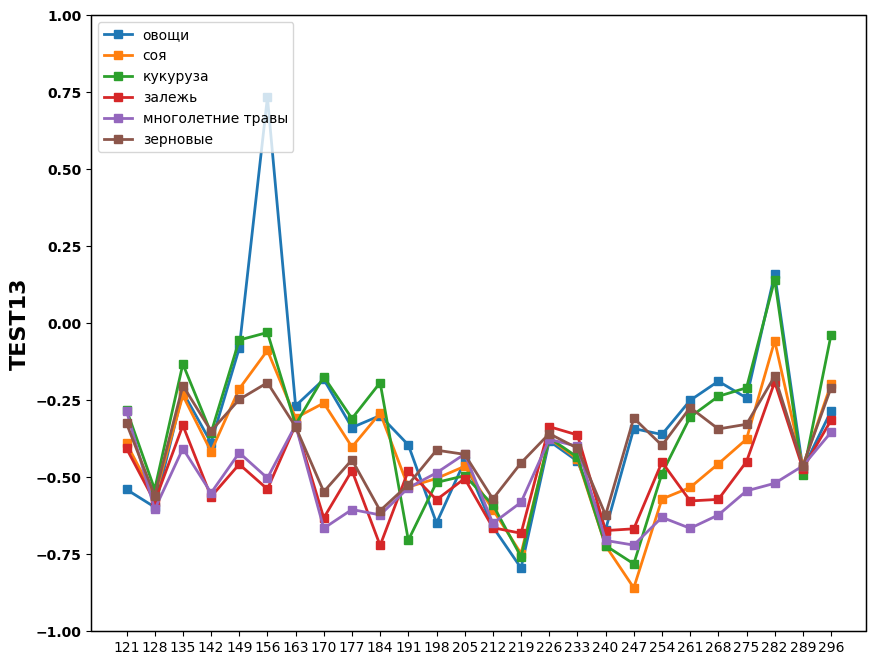

In [ ]:
#@title Create new dataframe
# Firstly make new dataframe then add it to previous block
fig, ax = plt.subplots(figsize=(10,8))
plt.yticks(fontsize=10)
ax.patch.set_edgecolor('black')
ax.patch.set_linewidth(1)

ax.set_ylabel('TEST13',fontsize = 16,fontweight="bold")
plt.ylim([-1.0, 1.0])

# create index's dataframe
df_test13 = pd.DataFrame()
for day in xx:  # Переберем все дни и создадим новый признак для каждого дня
    df_test13[f"{day}"] = ((df_nir[day] * df_re6[day] / 100000 - df_msavi[day] / 1000) / 4 + df_ndvwi[day] / 400 - df_test[day] * 1000) / 1000

df_test13[f"culture"] = df_nir["culture"]

# Process and make plot
for i in range(len(cul)):
    p = df_test13.loc[(df_test13['culture'] == cul[i])].drop(columns=['culture']).mean()
    ax.plot(xx, p.values.tolist(), label=cul[i], linestyle = '-', marker = 's', markersize = 6, linewidth = 2)
plt.yticks(size=10, fontweight="bold")
leg = ax.legend(fontsize=10, loc ='upper left')

plt.show()

In [ ]:
#@title Pipeline

# Create dataset, don't forget to compute it's parts before
df_features = df_ndvi.copy()

for day in xx:
    df_features[f"{day}_NDWI"] = df_ndwi[day]
    df_features[f"{day}_NDVWI"] = df_ndvwi[day]
    df_features[f"{day}_NDRE"] = df_ndre[day]
    df_features[f"{day}_MSAVI"] = df_msavi[day]
    df_features[f"{day}_NDSAVI"] = df_ndmsavi[day]
    df_features[f"{day}_NDVIRE"] = df_vire[day]
    df_features[f"{day}_2NDVI_2MSAVI_3NDWI"] = df_ndawi[day]
    df_features[f"{day}_RECI"] = df_reci[day]
    df_features[f"{day}_TEST"] = df_test[day]
    df_features[f"{day}_TEST2"] = df_test2[day]
    df_features[f"{day}_TEST3"] = df_test3[day]
    df_features[f"{day}_TEST4"] = df_test4[day]
    df_features[f"{day}_TEST5"] = df_test5[day]
    df_features[f"{day}_TEST6"] = df_test6[day]
    df_features[f"{day}_TEST7"] = df_test7[day]
    df_features[f"{day}_TEST8"] = df_test8[day]
    df_features[f"{day}_TEST9"] = df_test9[day]
    df_features[f"{day}_TEST10"] = df_test10[day]
    df_features[f"{day}_TEST11"] = df_test11[day]
    df_features[f"{day}_TEST12"] = df_test12[day]
    df_features[f"{day}_TEST13"] = df_test13[day]

# Transfer training part to 'x', answers part to 'y'    'y' now is 1D array
x = df_features.drop(columns=["culture"])
y = df_features['culture'].values

# Models
estimators = [
    ('lr4', CalibratedClassifierCV(estimator=LogisticRegression())), #
    ('rf2', CalibratedClassifierCV(estimator=RandomForestClassifier())), #
    ('rf3', ElasticNetCV()), #
    ('kn1', CalibratedClassifierCV(estimator=KNeighborsClassifier())), #
    ('kn2', CalibratedClassifierCV(estimator=NuSVC())), #
    ('s', CalibratedClassifierCV()), #
]

clfc = MLPClassifier(random_state=1, max_iter=3000, hidden_layer_sizes = (800, 600, 200, 100, 100, 50, 50), learning_rate='adaptive')

stacking_clf = StackingClassifier(estimators=estimators, final_estimator=clfc, n_jobs=-1)
# Pipeline
pipeline = Pipeline([
    ("imputer", SimpleImputer(missing_values=np.nan, strategy='mean')),
    ("scaler", StandardScaler()),
    ("clf", stacking_clf)
])

# # Split testing dataset
# x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)

pipeline.fit(x, y)

# # Train models in pipeline
# pipeline.fit(x_train, y_train)

# # Predict testing part
# ans = pipeline.predict(x_test)

# # Compare answers to prediction and print metrics
# print(classification_report(y_test, ans))

Pipeline(steps=[('imputer', SimpleImputer()), ('scaler', StandardScaler()),
                ('clf',
                 StackingClassifier(estimators=[('lr4',
                                                 CalibratedClassifierCV(estimator=LogisticRegression())),
                                                ('rf2',
                                                 CalibratedClassifierCV(estimator=RandomForestClassifier())),
                                                ('rf3', ElasticNetCV()),
                                                ('kn1',
                                                 CalibratedClassifierCV(estimator=KNeighborsClassifier())),
                                                ('kn2',
                                                 CalibratedClassifierCV(estimator=NuSVC())),
                                                ('s',
                                                 CalibratedClassifierCV())],
                                    final_estimator=MLPClassifier(hidden_layer_sizes=(800,
                                                                                      600,
                                                                                      200,
                                                                                      100,
                                                                                      100,
                                                                                      50,
                                                                                      50),
                                                                  learning_rate='adaptive',
                                                                  max_iter=3000,
                                                                  random_state=1),
                                    n_jobs=-1))])

In [ ]:
#@title Utils

# USE TO EXTRACT ans PREDICTIONS DATAFRAME

# dfew = pd.DataFrame(ans)
# dfew.to_csv("train/y.csv", sep=';', encoding="windows-1251", index=False) # Write

# DEPRECATED AND OUTDATED

# def retrain(rf_a):
#   #  Pipeline - инструмент для объединения последовательности нескольких обработок.
#   x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)
#   x_train = pipeline.transform(x_train)
#   x_test = pipeline.transform(x_test)
#   clf.partial_fit(x_train, y_train)

# for i in range(1000):
#   retrain(pipeline)
# ans = clf.predict(x_test)  # Получаем в каждой строке принадлежность к каждому классу
# pred_ans = np.zeros_like(ans).astype("int32")
# pred_ans[np.arange(len(ans)), ans.argmax(1)] = 1  # Расставляем единички в столбцах с максимумом
# print(classification_report(y_test, pred_ans))

#

# df_features = pd.read_csv("dataset1.csv", sep=';', encoding="windows-1251") # Read

# df_features.to_csv("train/dataset2.csv", sep=';', encoding="windows-1251", index=False) # Write

# Чтобы сохранить модель и не обучать её заново, можно сохранить её в файл следующим образом:
# with open("model.pkl", 'wb') as file:
#     pickle.dump(pipeline, file)

# Код для загрузки модели из файла:
with open('model.pkl', 'rb') as file:
    pipeline = pickle.load(file)

#### Запишем спрогнозированные ответы

In [ ]:
df_ndvi_t = pd.read_csv("drive/MyDrive/test/NDVI.csv", sep=";", encoding="windows-1251").drop(columns=["index"])
df_re5_t = pd.read_csv("drive/MyDrive/test/B05.csv", sep=";", encoding="windows-1251").drop(columns=["index"])  # B05 - канал со значениями RedEdge 705nm
df_nir_t = pd.read_csv("drive/MyDrive/test/B8A.csv", sep=";", encoding="windows-1251").drop(columns=["index"])  # B8A - канал со значениями NIR
df_swir_t = pd.read_csv("drive/MyDrive/test/B12.csv", sep=";", encoding="windows-1251").drop(columns=["index"])  # B12 - канал со значениями SWIR
df_re_t = pd.read_csv("drive/MyDrive/test/B07.csv", sep=";", encoding="windows-1251").drop(columns=["index"])  # B07 - канал со значениями RedEdge
df_red_t = pd.read_csv("drive/MyDrive/test/B04.csv", sep=";", encoding="windows-1251").drop(columns=["index"])  # B04 - канал со значениями Red
df_blue_t = pd.read_csv("drive/MyDrive/test/B02.csv", sep=";", encoding="windows-1251").drop(columns=["index"])  # B02 - канал со значениями Blue
df_green_t = pd.read_csv("drive/MyDrive/test/B03.csv", sep=";", encoding="windows-1251").drop(columns=["index"]) # B03 - канал со значениями Green
df_sir_t = pd.read_csv("drive/MyDrive/test/B11.csv", sep=";", encoding="windows-1251").drop(columns=["index"]) # B11 - канал со значениями SWIR 11 band
df_re6_t = pd.read_csv("drive/MyDrive/test/B06.csv", sep=";", encoding="windows-1251").drop(columns=["index"])  # B06 - канал со значениями RedEdge 740nm

In [ ]:
# drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
# with open('drive/MyDrive/model.pkl', 'rb') as file:
#     pipeline = pickle.load(file)

In [ ]:
# final test
df_ndvi_t = pd.read_csv("test/NDVI.csv", sep=";", encoding="windows-1251").drop(columns=["index"])
df_re5_t = pd.read_csv("test/B05.csv", sep=";", encoding="windows-1251").drop(columns=["index"])  # B05 - канал со значениями RedEdge 705nm
df_nir_t = pd.read_csv("test/B8A.csv", sep=";", encoding="windows-1251").drop(columns=["index"])  # B8A - канал со значениями NIR
df_swir_t = pd.read_csv("test/B12.csv", sep=";", encoding="windows-1251").drop(columns=["index"])  # B12 - канал со значениями SWIR
df_re_t = pd.read_csv("test/B07.csv", sep=";", encoding="windows-1251").drop(columns=["index"])  # B07 - канал со значениями RedEdge
df_red_t = pd.read_csv("test/B04.csv", sep=";", encoding="windows-1251").drop(columns=["index"])  # B04 - канал со значениями Red
df_blue_t = pd.read_csv("test/B02.csv", sep=";", encoding="windows-1251").drop(columns=["index"])  # B02 - канал со значениями Blue
df_green_t = pd.read_csv("test/B03.csv", sep=";", encoding="windows-1251").drop(columns=["index"]) # B03 - канал со значениями Green
df_sir_t = pd.read_csv("test/B11.csv", sep=";", encoding="windows-1251").drop(columns=["index"]) # B11 - канал со значениями SWIR 11 band
df_re6_t = pd.read_csv("test/B06.csv", sep=";", encoding="windows-1251").drop(columns=["index"])  # B06 - канал со значениями RedEdge 740nm

In [ ]:
df_features_t = df_ndvi_t.copy()  # Создадим таблицу для используемых признаков (copy NDVI at creation)

for day in xx:  # Переберем все дни и создадим новый признак для каждого дня
    df_features_t[f"{day}_NDWI"] = (df_nir_t[day] - df_swir_t[day]) / (df_nir_t[day] + df_swir_t[day])
    df_features_t[f"{day}_NDVWI"] = df_ndvi_t[day] * df_features_t[f"{day}_NDWI"]
    df_features_t[f"{day}_NDRE"] = ((df_nir_t[day] - df_re_t[day]) / (df_nir_t[day] + df_re_t[day]))
    df_features_t[f"{day}_MSAVI"] = ((2*(df_nir_t[day] + 1)) - ((2*df_nir_t[day]+1)**2 - 8 * (df_nir_t[day] - df_red_t[day])) ** (0.5)) / 8 + 0.4
    df_features_t[f"{day}_NDSAVI"] = df_ndvi_t[day] * (df_features_t[f"{day}_MSAVI"] / 2)
    df_features_t[f"{day}_NDVIRE"] = df_ndvi_t[day] * df_features_t[f"{day}_NDRE"]
    df_features_t[f"{day}_2NDVI_2MSAVI_3NDWI"] = ((((df_ndvi_t[day] * 2) * df_green_t[day] / 10) * ((df_features_t[f"{day}_MSAVI"] * 2) * (df_features_t[f"{day}_NDWI"] * 3) / df_red_t[day] * 2))) / 30
    df_features_t[f"{day}_RECI"] = ((df_nir_t[day] - df_re5_t[day]) / (2 * df_re5_t[day] - df_red_t[day])) / 6
    df_features_t[f"{day}_TEST"] = df_ndvi_t[day] * (df_features_t[f"{day}_MSAVI"] / 2) * (df_ndvi_t[day] * df_features_t[f"{day}_NDRE"]) + df_features_t[f"{day}_NDWI"] + 0.2
    df_features_t[f"{day}_TEST2"] = ((df_ndvi_t[day] * (df_re5_t[day] / 3) * (df_ndvi_t[day] * df_features_t[f"{day}_NDRE"]) + df_features_t[f"{day}_NDWI"]) + df_features_t[f"{day}_TEST"]) / 40
    df_features_t[f"{day}_TEST3"] = ((((df_ndvi_t[day] + df_red_t[day] - df_green_t[day] / 10) - (df_features_t[f"{day}_NDWI"] * df_features_t[f"{day}_NDRE"]) / 10 + df_features_t[f"{day}_NDWI"]) - df_features_t[f"{day}_TEST2"]) + df_features_t[f"{day}_TEST"]) / 10000
    df_features_t[f"{day}_TEST4"] = (df_features_t[f"{day}_TEST"] / 10 + (df_features_t[f"{day}_TEST3"] * df_re6_t[day]) / df_re5_t[day] * df_features_t[f"{day}_NDVWI"] + df_features_t[f"{day}_TEST"] * 2) / 5 - df_features_t[f"{day}_2NDVI_2MSAVI_3NDWI"] + df_re6_t[day] / 50000
    df_features_t[f"{day}_TEST5"] = (df_re6_t[day] / 50000 - df_re5_t[day] / 10000) * ((df_features_t[f"{day}_NDWI"] + 0.5)) + 0.7
    df_features_t[f"{day}_TEST6"] = ((df_re6_t[day] / 50000 - df_re5_t[day] / 10000 + 1) * ((df_features_t[f"{day}_NDWI"] + 0.5)) + df_features_t[f"{day}_NDRE"] * df_features_t[f"{day}_NDVWI"] - (df_ndvi_t[day] / (50 + df_nir_t[day] / 5000) + df_features_t[f"{day}_2NDVI_2MSAVI_3NDWI"] / 500 + df_features_t[f"{day}_TEST5"] / 100)) / 2
    df_features_t[f"{day}_TEST7"] = (df_ndvi_t[day] / 10000 - df_nir_t[day] + df_features_t[f"{day}_TEST"]) / 10000 + df_features_t[f"{day}_MSAVI"] / 5 + 0.7
    df_features_t[f"{day}_TEST8"] = (df_re5_t[day] + df_green_t[day] / df_red_t[day] * df_blue_t[day] / 500) / 15000
    df_features_t[f"{day}_TEST9"] = (df_re5_t[day] + df_sir_t[day] * (df_ndvi_t[day] + df_features_t[f"{day}_MSAVI"]) - df_features_t[f"{day}_NDRE"]) / 20000
    df_features_t[f"{day}_TEST10"] = (df_ndvi_t[day] + df_features_t[f"{day}_NDWI"]) * df_features_t[f"{day}_NDVWI"]
    df_features_t[f"{day}_TEST11"] = (((df_ndvi_t[day] + df_features_t[f"{day}_NDWI"]) * df_features_t[f"{day}_NDVWI"]) - (df_features_t[f"{day}_MSAVI"] / 10 + df_swir_t[day]) / 5000) / 2 + 0.5
    df_features_t[f"{day}_TEST12"] = (((df_ndvi_t[day] * 2 + df_features_t[f"{day}_NDWI"]) * df_features_t[f"{day}_NDVWI"]) - (df_features_t[f"{day}_RECI"] / 10 + df_swir_t[day]) / 5000) / 2
    df_features_t[f"{day}_TEST13"] = ((df_nir_t[day] * df_re6_t[day] / 100000 - df_features_t[f"{day}_MSAVI"] / 1000) / 4 + df_features_t[f"{day}_NDVWI"] / 400 - df_features_t[f"{day}_TEST"] * 1000) / 1000

In [ ]:
x = df_features_t

ans_test = pipeline.predict(x)

In [ ]:
y_test_t = pd.read_csv("classification_openset.csv", sep=";", encoding="windows-1251")
# ans_test = pd.read_csv("openset_ans.csv", sep=";", encoding="windows-1251")
print(classification_report(y_test_t, ans_test, digits=3))

                   precision    recall  f1-score   support

           залежь      0.986     0.994     0.990       349
         зерновые      0.991     0.994     0.993       350
         кукуруза      0.997     0.997     0.997       330
многолетние травы      1.000     0.995     0.997       191
            овощи      0.984     1.000     0.992       121
              соя      0.996     0.978     0.987       278

         accuracy                          0.993      1619
        macro avg      0.992     0.993     0.993      1619
     weighted avg      0.993     0.993     0.993      1619



In [ ]:
y_test_t = pd.read_csv("classification_closedset.csv", sep=";", encoding="windows-1251")
ans_test = pd.read_csv("closedset_ans.csv", sep=";", encoding="windows-1251")
print(classification_report(y_test_t, ans_test, digits=5))

                   precision    recall  f1-score   support

           залежь    0.99696   0.96755   0.98204       339
         зерновые    0.99713   0.99713   0.99713       349
         кукуруза    0.98876   1.00000   0.99435       352
многолетние травы    1.00000   1.00000   1.00000       184
            овощи    0.96078   0.97030   0.96552       101
              соя    0.96000   0.97627   0.96807       295

         accuracy                        0.98642      1620
        macro avg    0.98394   0.98521   0.98452      1620
     weighted avg    0.98658   0.98642   0.98643      1620



Формат ответа:
Первая строка состоит из одного слова "culture"
На каждой следующей строке названия культуры для спрогнозированных данных в том же порядке, что и тестовых данных.

In [ ]:
dfew = pd.DataFrame(ans_test)
dfew.columns = ['culture']
dfew.to_csv("predicted.csv", sep=';', encoding="windows-1251", index=False) # Write

In [ ]:
# dfew.to_csv("drive/MyDrive/test/predicted.csv", sep=';', encoding="windows-1251", index=False) # Write
# with open("drive/MyDrive/test/lastmodel.pkl", 'wb') as file:
#     pickle.dump(pipeline, file)
# from google.colab import runtime
# runtime.unassign()